In [ ]:
#PyTorch dependencies
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(0)



In [ ]:
batch_size = 128

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 117917515.15it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48845037.83it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36889279.20it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2309714.93it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

#GAN MODEL

In [ ]:
#@title Discriminator
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation
          followed by an nn.LeakyReLU activation with negative slope of 0.2
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True) #LeakyReLU activation
    )


In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Adding one more linear map to transform the final output into a single value
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

In [ ]:
#@title Generator
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )


In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)




#Model Instance

In [ ]:
# If a gpu is available move all models to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
#build the models
z_dim = 64
criterion = nn.BCEWithLogitsLoss()

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)



In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss


In [ ]:


def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the c1urrent batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss



In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)

#Training

In [ ]:
#@title Optimizer
lr = 0.00001 #learning_rate

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3898752540349957, discriminator loss: 0.41950720405578634


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6752324030399317, discriminator loss: 0.29897216156125045


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9659841814041146, discriminator loss: 0.17325322777032864


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7937147512435923, discriminator loss: 0.1905208448171615


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7299101560115802, discriminator loss: 0.195349921643734


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.030484372138976, discriminator loss: 0.14639615796506406


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.4522909774780275, discriminator loss: 0.12230550284683706


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7306671919822705, discriminator loss: 0.11429162846505642


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.172181282997134, discriminator loss: 0.10754750019311901


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.242779813289644, discriminator loss: 0.08984512169659137


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.5640420360565184, discriminator loss: 0.07979894122481351


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.5985009417533873, discriminator loss: 0.08212002481520177


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.7457990379333497, discriminator loss: 0.0682880281805991


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.947257243156433, discriminator loss: 0.06074557626247408


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.143262439250949, discriminator loss: 0.05715656872838737


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.9158584055900594, discriminator loss: 0.06438893875479705


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 3.853292801856996, discriminator loss: 0.07681766009330744


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.952814265727996, discriminator loss: 0.06136363840848206


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 3.888474936962126, discriminator loss: 0.06902168708294627


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 3.8397518043518066, discriminator loss: 0.06661466062068941


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 3.9857326750755293, discriminator loss: 0.05643757273629311


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 3.8595771203041056, discriminator loss: 0.07819519378244875


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 3.845310990333555, discriminator loss: 0.07634957600384956


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 4.056266957759862, discriminator loss: 0.0722028999961913


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 4.031938589096068, discriminator loss: 0.07150723380967972


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 3.9547788691520696, discriminator loss: 0.07796369250863783


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 3.826873798370358, discriminator loss: 0.08723985454440113


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 4.101991032123563, discriminator loss: 0.08021846417337658


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 4.032018096923827, discriminator loss: 0.0857000877484679


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.8007321710586557, discriminator loss: 0.10362019255012271


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 3.992464286327364, discriminator loss: 0.0921918767914176


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 3.9363937854766853, discriminator loss: 0.09429422741383302


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 3.9787136063575756, discriminator loss: 0.10023109647631638


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 3.7742501940727267, discriminator loss: 0.11600439680367715


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.469788578987121, discriminator loss: 0.1337858378365635


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.7541748833656308, discriminator loss: 0.09757165162265295


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 3.7530207896232604, discriminator loss: 0.11677337472885853


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.582136636734011, discriminator loss: 0.1280171808004379


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.510376843452453, discriminator loss: 0.12861403596401214


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.311220303535462, discriminator loss: 0.14531940430402762


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.3402681293487597, discriminator loss: 0.13717277525365346


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.2567877788543727, discriminator loss: 0.15217671774327762


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 3.5307351045608533, discriminator loss: 0.12085357717424643


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 3.559797295093536, discriminator loss: 0.1353979045972227


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 3.3290032277107255, discriminator loss: 0.16706359390914458


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 3.2878385624885573, discriminator loss: 0.1617787691205739


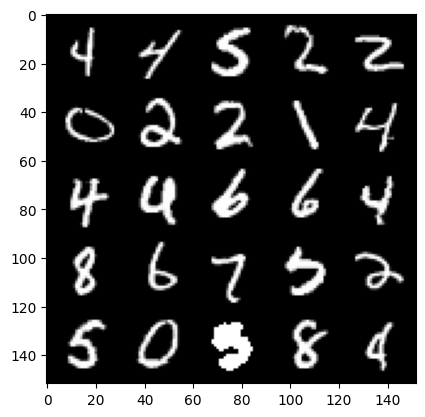

In [ ]:
n_epochs = 50
display_step = 500
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

# Keep track of losses
disc_losses = []
gen_losses = []

test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_losses.append(disc_loss.item())

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
